In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import shap
import lime
import lime.lime_tabular


In [2]:
# Step 1: Load the data
file_path = '/Users/arkamandol/DataspellProjects/Desertation_arka_23023023/data_files/data_trdnl_mdl_shap_vs_lime.csv'
data = pd.read_csv(file_path)

In [3]:

# Step 2: Data Preprocessing
# Keep 'Month' as a single variable and select one feature from each group
data = data.drop(columns=['Month'])  # Drop month initially for selection
prefixes = ['Migrant', 'Education', 'Economy', 'Ethnic', 'Employment']
selected_columns = []

for prefix in prefixes:
    prefix_columns = [col for col in data.columns if col.startswith(prefix)]
    corr_with_target = data[prefix_columns].corrwith(data['crime_count']).abs()
    best_column = corr_with_target.idxmax()
    selected_columns.append(best_column)

data = pd.read_csv(file_path)  # Reload data to include 'Month'
selected_columns_with_month = ['Month'] + selected_columns + ['crime_count']
data_with_month = data[selected_columns_with_month]

# Feature Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_with_month.drop(columns=['Month', 'crime_count']))
scaled_features_df = pd.DataFrame(scaled_features, columns=selected_columns)
final_data = pd.concat([data_with_month[['Month']], scaled_features_df, data_with_month['crime_count']], axis=1)

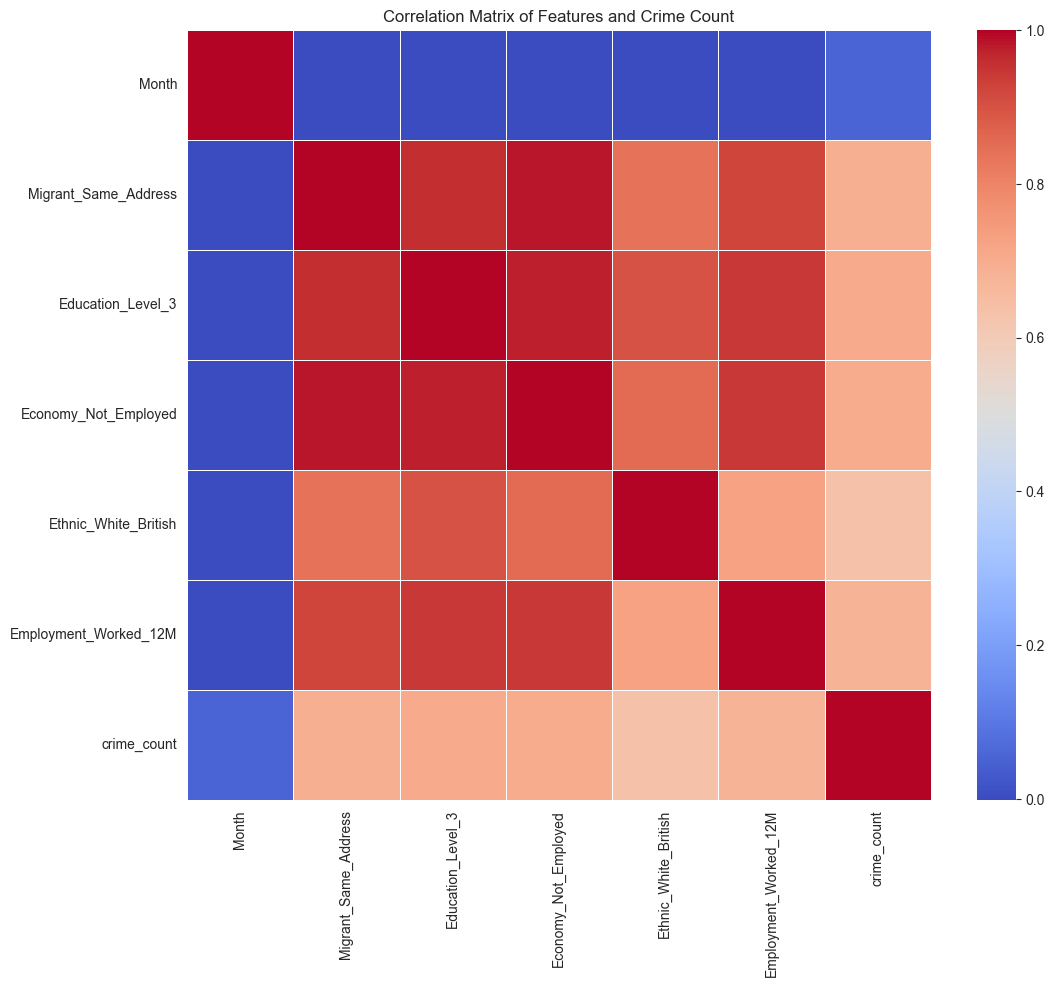

In [5]:
# Convert 'Month' to a numerical format (e.g., ordinal encoding)
final_data['Month'] = pd.to_datetime(final_data['Month']).astype(int) // 10**9  # Convert to numeric timestamp

# Step 3: Correlation Matrix Visualization
corr_matrix = final_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Features and Crime Count')
plt.show()


In [6]:
# Step 4: Train-Test Split
X = final_data.drop(columns=['crime_count'])
y = final_data['crime_count']
X['Month'] = pd.to_datetime(X['Month']).astype(int) // 10**9  # Convert Month to numeric timestamp
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
# Step 5: Model Training and Evaluation
# Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

In [8]:
# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

Random Forest Evaluation:
R-squared (R²): 0.8111
Mean Squared Error (MSE): 48819.7443

Linear Regression Evaluation:
R-squared (R²): 0.5964
Mean Squared Error (MSE): 104313.2693


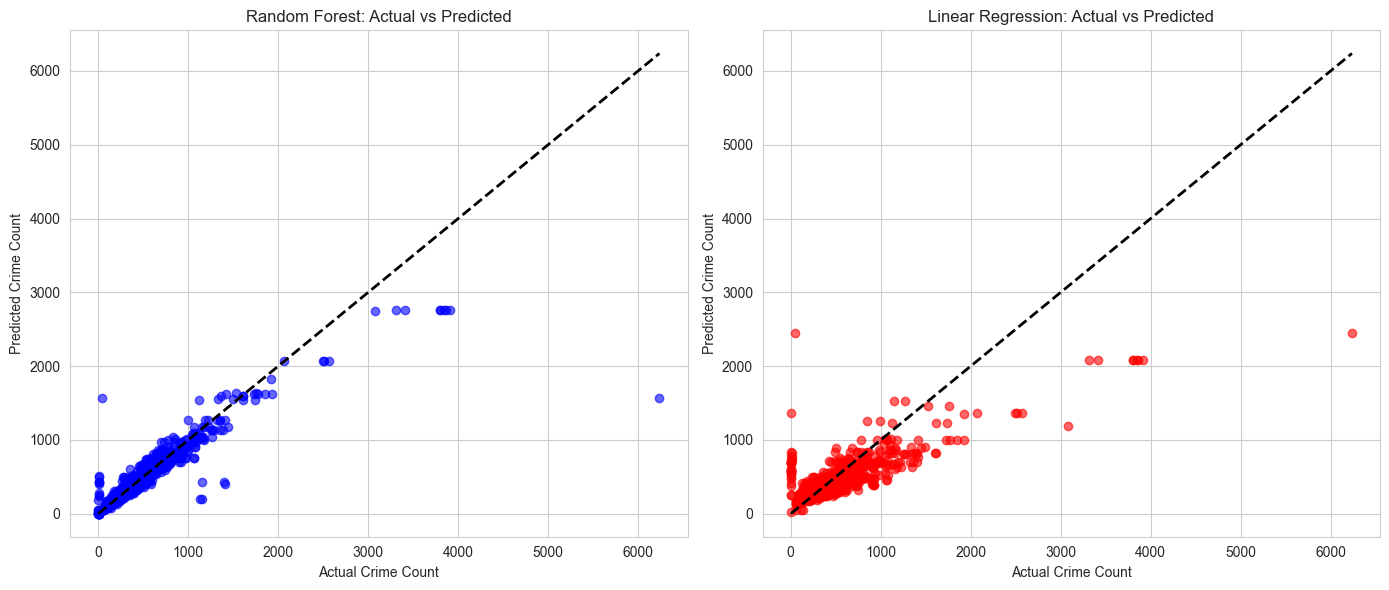

In [14]:
# Evaluate Random Forest
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Evaluate Linear Regression
y_pred_linear = linear_model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# Print Evaluation Metrics
print("Random Forest Evaluation:")
print(f"R-squared (R²): {r2_rf:.4f}")
print(f"Mean Squared Error (MSE): {mse_rf:.4f}\n")

print("Linear Regression Evaluation:")
print(f"R-squared (R²): {r2_linear:.4f}")
print(f"Mean Squared Error (MSE): {mse_linear:.4f}\n")

# Visualizing the Predictions vs Actual Values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel('Actual Crime Count')
plt.ylabel('Predicted Crime Count')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_linear, alpha=0.6, color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Crime Count')
plt.ylabel('Predicted Crime Count')

plt.tight_layout()
plt.show()


In [9]:
# Step 6: Feature Importance Visualization
# Random Forest Feature Importance
importances_rf = rf_model.feature_importances_
importance_df_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances_rf}).sort_values(by='Importance', ascending=False)

In [10]:
# Linear Regression Coefficients
coefficients_lr = linear_model.coef_
importance_df_lr = pd.DataFrame({'Feature': X_train.columns, 'Importance': coefficients_lr}).sort_values(by='Importance', ascending=False)

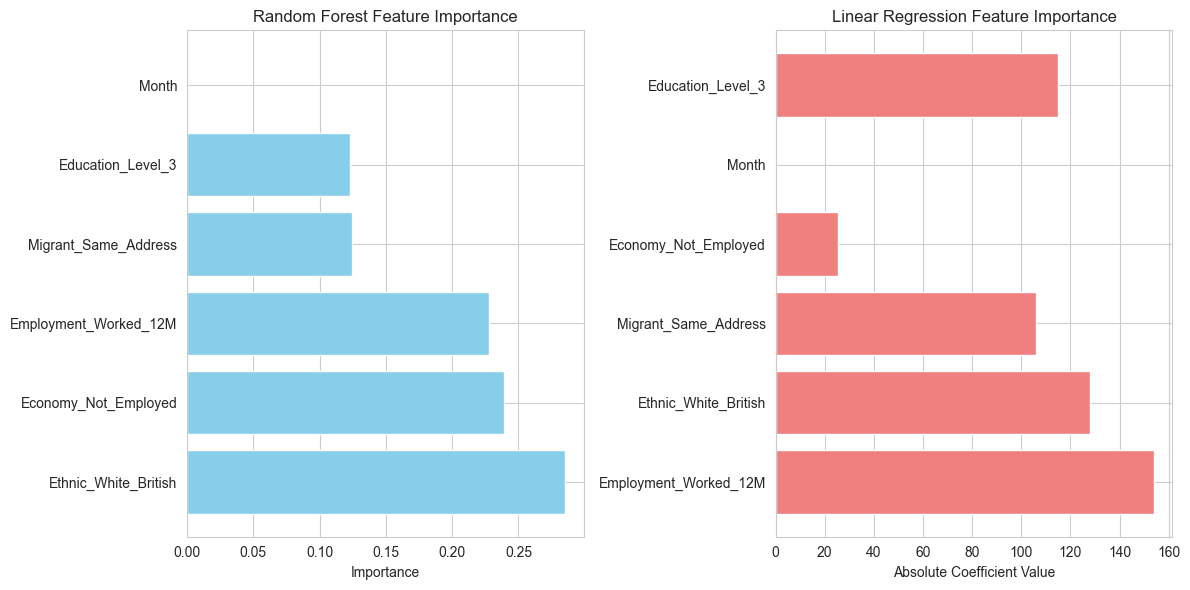

In [11]:
# Visualization of Feature Importances
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(importance_df_rf['Feature'], importance_df_rf['Importance'], color='skyblue')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')

plt.subplot(1, 2, 2)
plt.barh(importance_df_lr['Feature'], abs(importance_df_lr['Importance']), color='lightcoral')
plt.title('Linear Regression Feature Importance')
plt.xlabel('Absolute Coefficient Value')

plt.tight_layout()
plt.show()

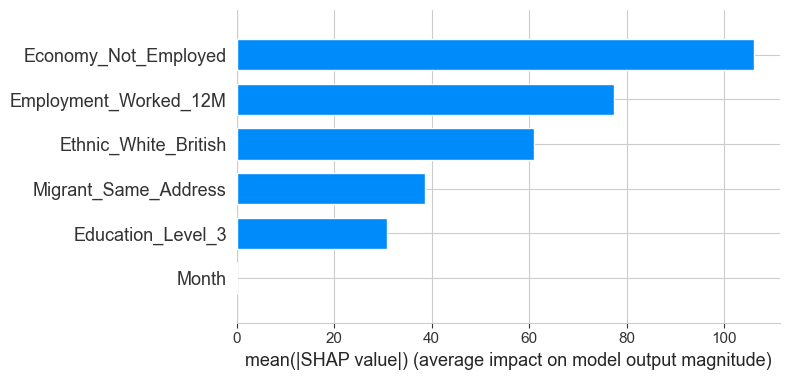

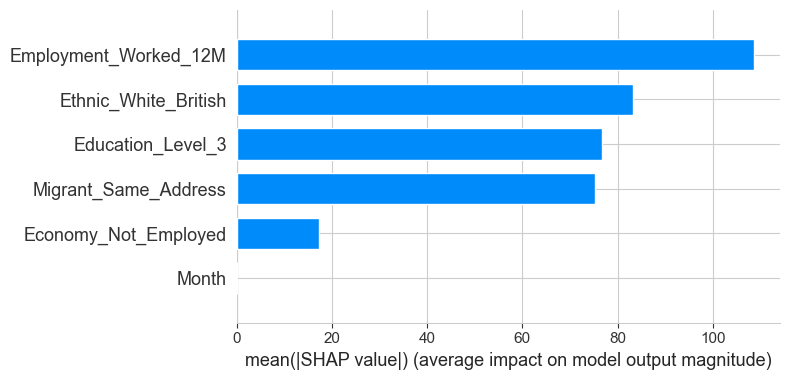

In [12]:
# Step 7: SHAP Values for Interpretation
# Random Forest SHAP
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)
shap.summary_plot(shap_values_rf, X_test, plot_type="bar")

# Linear Regression SHAP
explainer_lr = shap.LinearExplainer(linear_model, X_train)
shap_values_lr = explainer_lr.shap_values(X_test)
shap.summary_plot(shap_values_lr, X_test, plot_type="bar")

### 1. **Linear Regression Model Insights (First Image)**

#### Feature Importance (Mean |SHAP| Value):
- **Employment_Worked_12M:** This feature has the highest average impact on the model’s predictions. This means that whether someone worked in the last 12 months is the most influential factor in the linear regression model.
  
- **Ethnic_White_British:** The second most impactful feature. Ethnicity, specifically being White British, plays a significant role in influencing the predictions.
  
- **Education_Level_3:** Education level has a strong influence, indicating that the model heavily considers educational attainment in its predictions.
  
- **Migrant_Same_Address:** Migrant status, specifically whether a person is residing at the same address, is also an important factor, although slightly less impactful than the top three features.
  
- **Economy_Not_Employed:** This feature has a smaller, yet still notable, impact on the model’s output, reflecting the influence of employment status on the predictions.
  
- **Month:** The least impactful feature, indicating that the month of data collection has minimal effect on the predictions in the linear model.

### 2. **Random Forest Model Insights (Second Image)**

#### Feature Importance (Mean |SHAP| Value):
- **Economy_Not_Employed:** This feature has the highest average SHAP value, suggesting that employment status is the most crucial factor in the random forest model. This is a shift from the linear model, where `Employment_Worked_12M` was the most important.

- **Employment_Worked_12M:** While still highly important, its influence is slightly reduced compared to the linear model, indicating that the random forest model balances this feature's impact with others.
  
- **Ethnic_White_British:** Similar to the linear model, ethnicity remains a key factor in the random forest model’s predictions.

- **Migrant_Same_Address:** This feature is also important in the random forest model, consistent with its ranking in the linear model, though its impact is slightly reduced.
  
- **Education_Level_3:** Interestingly, this feature is less influential in the random forest model compared to the linear model, which might suggest different interactions with other features in the model.
  
- **Month:** As with the linear model, this feature has the least impact, confirming that the timing of data collection does not significantly influence the predictions.

### **Comparative Insights:**

- **Employment-Related Features:** 
  - Both models highlight the importance of employment status (`Employment_Worked_12M` and `Economy_Not_Employed`), but the random forest model places more emphasis on the unemployment feature (`Economy_Not_Employed`).
  
- **Ethnicity and Migrant Status:**
  - Both models show that ethnicity and migrant status have significant impacts, with consistent importance across the models.
  
- **Education Level:**
  - While education level is influential in both models, it is more prominent in the linear regression model, indicating that the linear model may consider this feature more directly or with less interaction with other variables compared to the random forest model.
  
- **Month:**
  - The minimal impact of the month across both models suggests that temporal factors are less relevant to the outcome being predicted.

### **Conclusion:**
- Both models agree on the importance of employment status, ethnicity, and migrant status, but they differ slightly in how much weight they assign to each feature. The linear model is more sensitive to education level, while the random forest model emphasizes the employment-related features slightly more.
- Understanding these differences helps in selecting or refining the model based on the importance of specific features, especially when interpreting the results or making decisions based on these models.

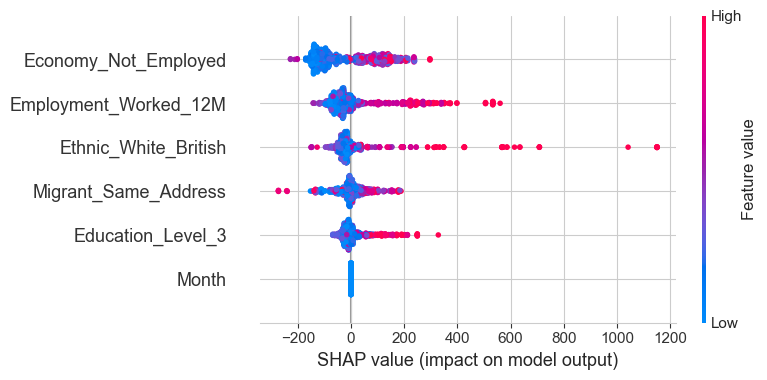

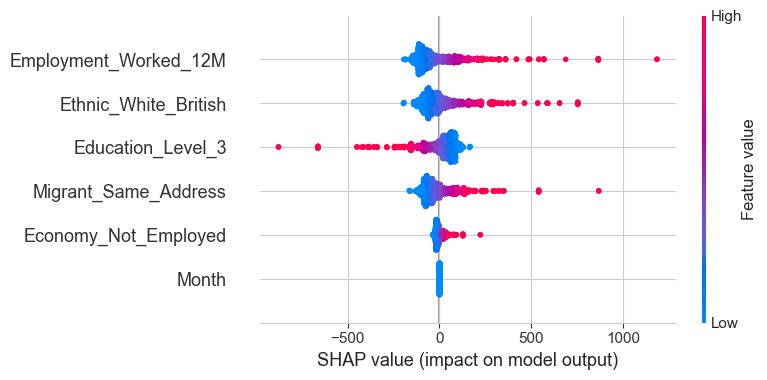

In [16]:
# Random Forest SHAP
shap.summary_plot(shap_values_rf, X_test)

# Linear Regression SHAP
shap.summary_plot(shap_values_lr, X_test)

### 1. **Linear Regression Model (First SHAP Plot)**

#### General Observations:
- The SHAP values indicate how much each feature contributes to increasing or decreasing the prediction. Features with a high positive SHAP value increase the prediction, while those with a negative SHAP value decrease it.
- The color gradient (blue to red) represents the actual value of the feature, with blue indicating lower values and red indicating higher values.

#### Feature Insights:
- **Employment_Worked_12M:**
- High SHAP values for higher feature values (red points on the right) show that more recent employment contributes significantly to increasing the predicted value.
- Conversely, low employment (blue points) decreases the prediction.

- **Ethnic_White_British:**
- Higher SHAP values when this feature has higher values suggest that being identified as White British is positively associated with the prediction.

- **Education_Level_3:**
- Lower levels of education (blue points) generally contribute negatively, whereas higher levels (red points) have a positive but smaller impact on the prediction.

- **Migrant_Same_Address:**
- Being a migrant with the same address tends to increase the prediction, especially for higher values (red points).

- **Economy_Not_Employed:**
- The impact of unemployment has a mixed influence, with higher unemployment sometimes decreasing the prediction (left side) but also showing instances of slight positive contributions.

- **Month:**
- The impact of the month seems minimal, with SHAP values close to zero, indicating that this feature does not strongly influence the model's output.

### 2. **Random Forest Model (Second SHAP Plot)**

#### General Observations:
- The feature order here differs slightly from the linear model, indicating a different importance ranking or interaction with other features.

#### Feature Insights:
- **Economy_Not_Employed:**
- Unlike the linear model, here, unemployment has a more pronounced negative impact (left side), with lower values (blue) generally decreasing the prediction.

- **Employment_Worked_12M:**
- Similar to the linear model, recent employment significantly increases the prediction, especially for higher feature values (red points).

- **Ethnic_White_British:**
- Consistent with the linear model, being White British increases the prediction, although the distribution is slightly wider, indicating a more varied influence.

- **Migrant_Same_Address:**
- The positive impact of migrants living at the same address is evident but less consistent compared to the linear model, indicating more variability in how this feature affects the prediction.

- **Education_Level_3:**
- Similar to the linear model, higher education levels generally contribute positively, but the effect is more varied here, with some negative impacts seen even at higher education levels.

- **Month:**
- As with the linear model, the month has minimal impact, with most SHAP values centered around zero, suggesting it does not heavily influence predictions.

### **Comparative Insights:**
- **Consistency:** Both models highlight the importance of features like `Employment_Worked_12M`, `Ethnic_White_British`, and `Education_Level_3` but with some differences in how these features impact the predictions.
- **Model Specific Differences:**
- The random forest model shows more variability in SHAP values for some features, which is expected given the model's ability to capture complex interactions.
- `Economy_Not_Employed` has a more pronounced negative effect in the random forest model, while its impact is more nuanced in the linear model.

- **Impact of Features:**
- The linear regression model seems to apply a more consistent interpretation across features, while the random forest model shows more variability, likely due to the model's capacity to capture non-linear relationships and interactions between features.

### **Conclusion:**
- The SHAP analysis confirms the importance of key features across both models, with the random forest model capturing more complex interactions and variances in feature impact.
- Understanding these SHAP values can help refine feature selection, improve model interpretation, and guide further adjustments to either model based on specific feature behaviors.

In [13]:
# Step 8: LIME for Interpretation
# Random Forest LIME
explainer_rf_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    mode='regression'
)
instance_to_explain = X_test.iloc[0]
explanation_rf = explainer_rf_lime.explain_instance(
    data_row=instance_to_explain.values,
    predict_fn=rf_model.predict
)
explanation_rf.show_in_notebook(show_table=True)

# Linear Regression LIME
explainer_lr_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    mode='regression'
)
explanation_lr = explainer_lr_lime.explain_instance(
    data_row=instance_to_explain.values,
    predict_fn=linear_model.predict
)
explanation_lr.show_in_notebook(show_table=True)



/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(



### 1. **Linear Regression Model Insights (First Image)**

#### Predicted Value:
- **Predicted Value:** 722.01
- **Range:** The prediction lies between -276.77 (min) and 1697.34 (max).

#### Feature Importance:
- **Positive Features (influence increasing the prediction):**
  - **Employment_Worked_12M (330.05):** This feature has the highest positive impact on the predicted value.
  - **Ethnic_White_British (261.74):** This feature significantly contributes positively.
  - **Migrant_Same_Address (232.02):** Another strong positive contributor.
  - **Economy_Not_Employed (54.21):** Minor positive impact.

- **Negative Features (influence decreasing the prediction):**
  - **Education_Level_3 (236.79):** This feature significantly decreases the predicted value.

#### Feature Values:
- The corresponding values for these features show the model's basis for the prediction:
  - **Employment_Worked_12M:** 1.04
  - **Ethnic_White_British:** 0.33
  - **Education_Level_3:** 0.41
  - **Migrant_Same_Address:** 1.00
  - **Economy_Not_Employed:** 0.49
  - **Month:** 1.00

### 2. **Random Forest Model Insights (Second Image)**

#### Predicted Value:
- **Predicted Value:** 663.52
- **Range:** The prediction lies between 88.96 (min) and 1601.23 (max).

#### Feature Importance:
- **Positive Features (influence increasing the prediction):**
  - **Employment_Worked_12M (197.74):** The most impactful feature positively influencing the prediction.
  - **Ethnic_White_British (113.03):** Also has a significant positive influence.
  - **Education_Level_3 (97.02):** This feature contributes positively but less so compared to the linear model.
  - **Migrant_Same_Address (61.49):** Moderate positive contribution.
  - **Economy_Not_Employed (44.30):** Minor positive impact.

- **Negative Features:**
  - **Month:** Has no negative impact on the predicted value, as indicated by the 0.00 negative contribution.

#### Feature Values:
- The corresponding values for these features are consistent with those in the linear regression model:
  - **Employment_Worked_12M:** 1.04
  - **Ethnic_White_British:** 0.33
  - **Education_Level_3:** 0.41
  - **Migrant_Same_Address:** 1.00
  - **Economy_Not_Employed:** 0.49
  - **Month:** 1.00

### **Comparative Insights:**
- **Employment_Worked_12M** and **Ethnic_White_British** are the most influential positive features in both models.
- **Education_Level_3** is negatively impactful in the linear model but has a positive influence in the random forest model, suggesting model-specific interactions.
- **Migrant_Same_Address** and **Economy_Not_Employed** are consistently positive across both models but with varying degrees of impact.
- The linear model has a broader range for predicted values, while the random forest model predicts a lower range, which might suggest differences in the models' sensitivity to feature interactions.

### **Conclusion:**
- Both models have similar key features driving predictions, but the impact and direction (positive/negative) vary, indicating differences in how each model interprets feature importance and interactions.
- The linear regression model shows stronger individual impacts, while the random forest model distributes the importance more evenly across features.
  
This comparison can help in understanding how different models interpret data and in selecting the appropriate model for the prediction task based on the importance of specific features.